# P5 - Segmentez des clients d'un site e-commerce

### CLUSTERING - APPRENTISSAGE NON SUPERVISÉ
 
 - Basé sur des échantillons d'apprentissage
 - Pas de target, recherche de structures naturelles dans les données à partir des features 

Pour ce faire il faut : 

- Clustering (segmentation, regroupement) 
- analyser les relations et détecter des associations entre features
- Réduction de dimensions.

In [1]:
# chargement librairies 
import numpy as np
import pandas as pd
from math import pi

# Data visualisation
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pré processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Réduction dimension
from sklearn.manifold import TSNE
from sklearn import decomposition,manifold
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import cluster, metrics
from scipy.cluster.hierarchy import linkage, fcluster

# Clustering Visualisation
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram

# Clustering Metrics
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
import statistics
# Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


### Clustering : méthodes choisies et bref explication

Les techniques de clustering cherchent à décomposer un ensemble d'individus en plusieurs sous ensembles les plus homogènes possibles sans connaître la classe des exemples (nombre, forme, taille...).

Méthodes de clustering :

méthodes K-Means : une classe est représentée par son centre de gravité (ex : K-Means).
  
Méthodes hiérarchiques : les clusters sont organisés sous la forme d'une structure d'arbre (le nombre de clusters n'est pas défini) en utilisant les distances entre les classes.
approche hiérarchique ascendante RHA (ou agglomération) : on commence avec un objet dans chaque classe, puis on fusionne successivement les 2 classes les plus proches et on s'arrête quand il n'y a plus qu'une classe contenant tous les exemples (recherche : BIRCH (1996) : basée sur la représentation d'une classe par ses traits caractéristiques et CHAMELEON (1999) : basée sur la théorie des graphes et une représentation plus riche des données).


DBSCAN : utilisation de la densité à la place de la distance. Les clusters sont des régions de l'espace qui ont une grande densité de points
Un point est dense si le nombre de ses voisins dépasse un certain seuil
Un point est voisin d'un autre point s'il est à une distance inférieure à une valeur fixée.


## Dataset 

In [2]:
# chargement données
data=pd.read_csv('data_client_clean.csv')
# creation copy
data_client=data.copy()

In [3]:
# dimensions
data.shape

(91212, 14)

In [205]:
# contenu 
data.head(3)

customer_unique_id customer_city customer_state  \
0  0000366f3b9a7992bf8c76cfdf3221e2       cajamar             SP   
1  0000b849f77a49e4a4ce2b2a4ca5be3f        osasco             SP   
2  0000f46a3911fa3c0805444483337064      sao jose             SC   

  product_category_name  recence  freq  montant_sum  harvesine_distance  \
0                  home    111.0   1.0       141.90          211.642212   
1               fashion    114.0   1.0        27.19          203.596053   
2               various    536.0   1.0        86.22          151.425065   

    date_dernier_achat  scor_avg  echeance_paiement_avg  panier_moyen  \
0  2018-05-10 10:56:27       5.0                    8.0         129.9   
1  2018-05-07 11:11:27       4.0                    1.0          18.9   
2  2017-03-10 21:05:03       3.0                    8.0          69.0   

  moyen_paiement_prefere  frais_port_avg  
0            credit_card           12.00  
1            credit_card            8.29  
2            credit_card           17.22

### preprocessing

Nous avons constaté lors de l'analyse exploratoire que pour les données qualitatives il y'a plus de 97% de clients qui ont effecté des achats 1 fois. Nous ne procèderons donc pas à la standardisation de cette variable et nous la gardons. 

In [4]:
# Sélection des variables qualitatives
cols_cat=data.select_dtypes(exclude=[np.number]).columns.tolist()
data_cat=data[cols_cat]
data_cat.shape

(91212, 6)

In [5]:
# Encodage du moyen de paiement préféré
encod_paiement = pd.get_dummies(data_cat['moyen_paiement_prefere'])
X_cat = data_cat.join(encod_paiement)

In [6]:
# Encodage type de produit
encod_cat_pref = pd.get_dummies(data_cat['product_category_name'])
X_cat = data_cat.join(encod_cat_pref)

In [7]:
X_cat.drop(['customer_unique_id','customer_city','customer_state','product_category_name','moyen_paiement_prefere'],axis=1,inplace=True)

In [8]:
X_cat.columns.tolist()

['date_dernier_achat',
 'construction',
 'fashion',
 'food',
 'high_technology',
 'home',
 'leisure',
 'various']

In [9]:
# Sélection des variables numériques
cols_num = data.select_dtypes(include=[np.number]).columns.tolist()
data_num = data[cols_num]
data_num.shape

(91212, 8)

In [10]:
data_num=data_num.drop('freq',axis=1)
data_num.describe()


recence    montant_sum  harvesine_distance      scor_avg  \
count  91212.000000   91212.000000        91212.000000  91212.000000   
mean     236.109415     212.352124          446.477711      4.154497   
std      152.573347     631.928631          380.258721      1.279310   
min        0.000000       9.590000            0.421436      1.000000   
25%      113.000000      63.830000          211.637510      4.000000   
50%      217.000000     112.880000          307.821253      5.000000   
75%      344.000000     202.760000          508.320035      5.000000   
max      694.000000  109312.640000         5336.639365      5.000000   

       echeance_paiement_avg  panier_moyen  frais_port_avg  
count           91212.000000  91212.000000    91212.000000  
mean                2.903366    125.684734       20.206554  
std                 2.680293    188.801809       15.735078  
min                 0.000000      0.850000        0.000000  
25%                 1.000000     42.900000       13.370000  
50%                 2.000000     79.000000       16.422500  
75%                 4.000000    139.900000       21.220000  
max                24.000000   6735.000000      409.680000

In [11]:
# Transformation en logarithme pour avoir le même poids
data_num_log = data_num.apply(np.log1p, axis=1)

In [12]:
X_scaled=data_num_log

In [13]:
# Standardisation StandardScaler
# Préparation des données
X = data_num_log.values
features_acp_log = data_num_log.columns

# Standardisation avec StandardScaler (rendla distribution plus normale)
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)

# Dataframe
X_scaled = pd.DataFrame(X_scaled,index=data_num_log.index,columns=features_acp_log)

In [14]:
freq=pd.DataFrame(data_client.freq)

In [15]:
X_scaled=pd.concat([X_scaled,freq],axis=1)
X_scaled.describe()

recence   montant_sum  harvesine_distance      scor_avg  \
count  9.121200e+04  9.121200e+04        9.121200e+04  9.121200e+04   
mean  -2.033510e-16  1.236640e-16       -3.470354e-16 -1.641295e-15   
std    1.000005e+00  1.000005e+00        1.000005e+00  1.000005e+00   
min   -5.403015e+00 -2.701081e+00       -6.153046e+00 -2.690498e+00   
25%   -4.340315e-01 -7.062653e-01       -4.908717e-01  4.549600e-02   
50%    2.461290e-01 -8.599984e-02       -6.894515e-02  5.898983e-01   
75%    7.277407e-01  5.545464e-01        4.967316e-01  5.898983e-01   
max    1.462531e+00  7.474230e+00        3.153136e+00  5.898983e-01   

       echeance_paiement_avg  panier_moyen  frais_port_avg          freq  
count           9.121200e+04  9.121200e+04    9.121200e+04  91212.000000  
mean           -6.176690e-16 -6.728198e-17   -2.233993e-16      1.237666  
std             1.000005e+00  1.000005e+00    1.000005e+00      0.844734  
min            -2.072153e+00 -4.181382e+00   -5.782071e+00      1.000000  
25%            -8.545577e-01 -6.666278e-01   -4.865212e-01      1.000000  
50%            -1.423104e-01 -5.627924e-04   -1.037921e-01      1.000000  
75%             7.550151e-01  6.276674e-01    3.794985e-01      1.000000  
max             3.582183e+00  4.919843e+00    6.175126e+00     75.000000

In [79]:
# visualisation distribution
def graph (df):
    plt.figure(figsize=(20, 10))
    axes = plt.axes()
   
    for col in df.columns:
        label = col
        sns.kdeplot(df[col])
    plt.xlabel('')
    plt.show()

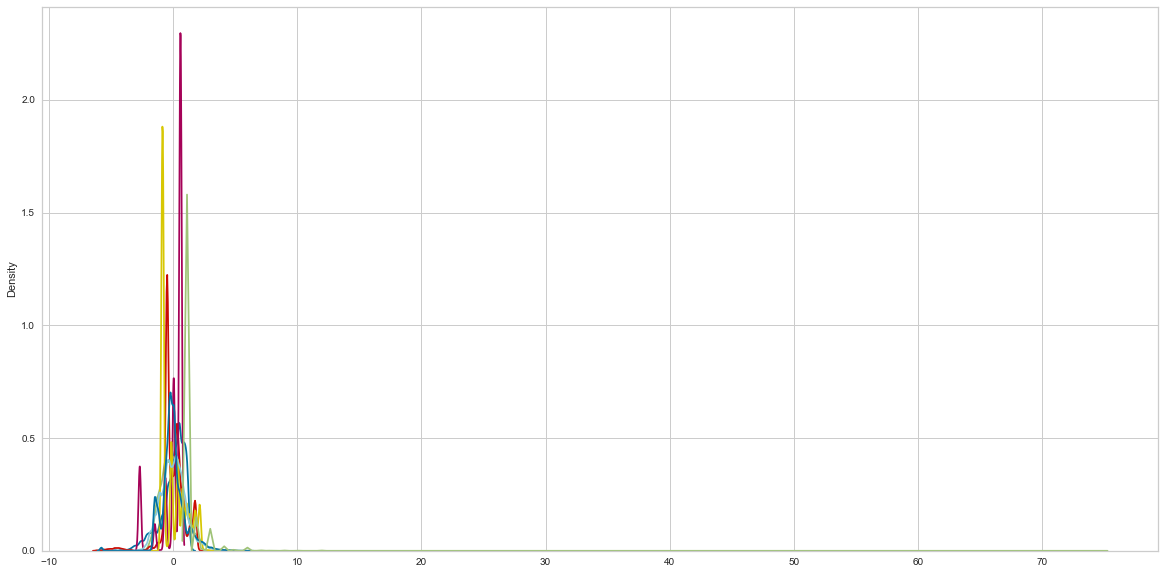

In [80]:
graph(X_scaled)

## ACP: Reduction de dimensions
ACP
Le but est de réduire le nombre de dimensions d'un ensemble de données tout en conservant la plupart des informations.
Elle utilise la corrélation entre certaines dimensions et tente de fournir un nombre minimum de variables qui conserve le maximum de variation ou d'informations sur la façon dont les données originales sont distribuées.

In [81]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

### ACP sur données quantitatives 

In [82]:
# choix du nombre de composantes à calculer
n_comp = 8

In [83]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=8)

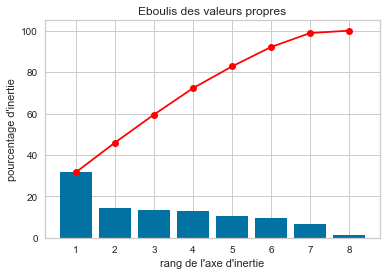

In [84]:
# Eboulis des valeurs propres
display_scree_plot(pca)


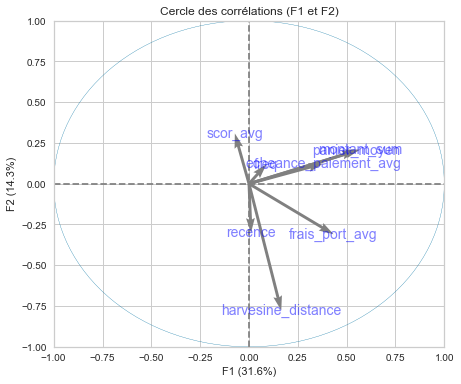

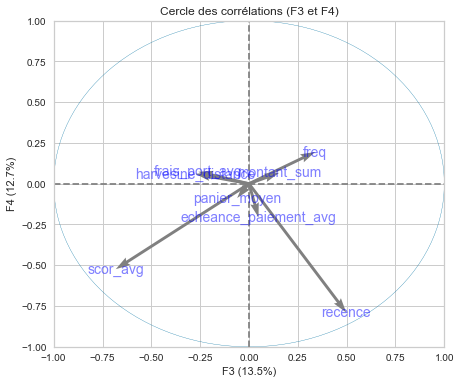

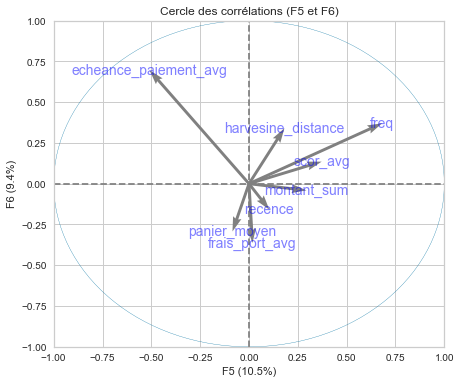

In [85]:
# Cercle des corrélations
pcs = pca.components_
names=X_scaled.index
features=X_scaled.columns
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

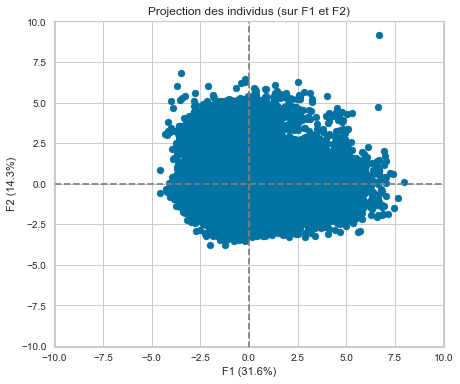

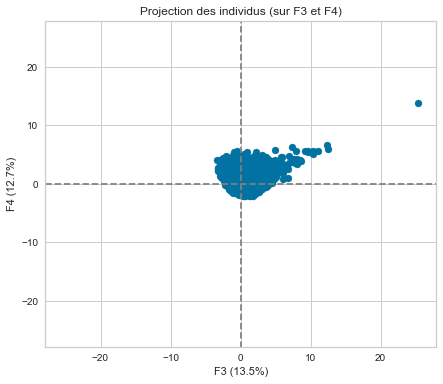

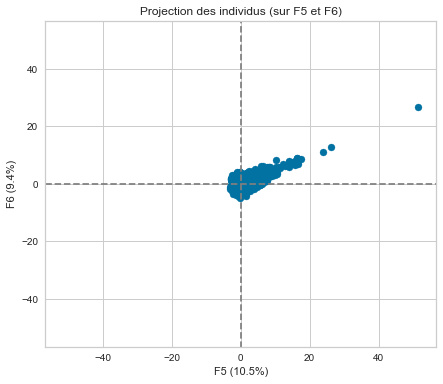

In [86]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)])

plt.show()

In [87]:
# ACP avec 5 composantes
n_comp = 5
pca= PCA(n_components=n_comp)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
pca.explained_variance_ratio_

array([0.31629698, 0.14325066, 0.13528643, 0.12746218, 0.10505804])

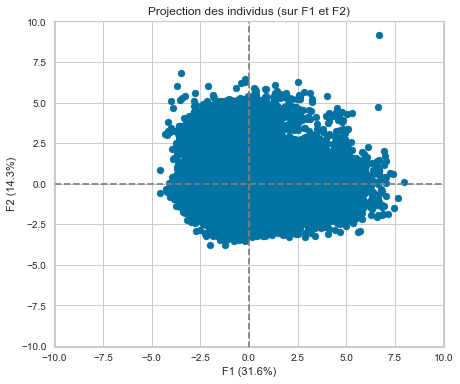

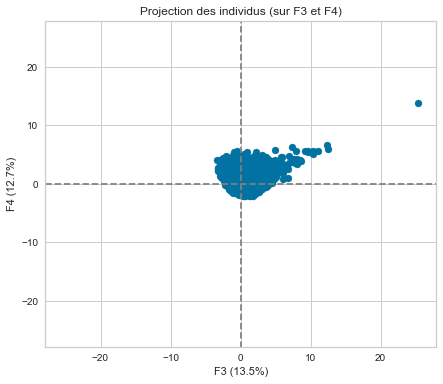

In [410]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)])

plt.show()

### ACP avec ajout des données qualitatives 

In [103]:
df=pd.concat([X_scaled,X_cat],axis=1)
df.shape

(91212, 15)

In [108]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=15)
pca.fit(df)

PCA(n_components=15)

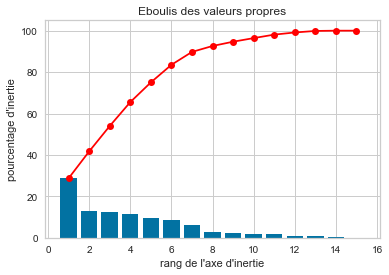

In [109]:
# Eboulis des valeurs propres
display_scree_plot(pca)


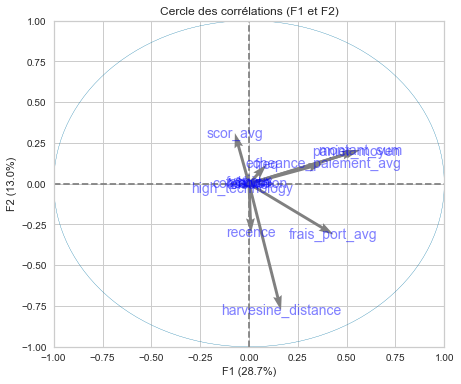

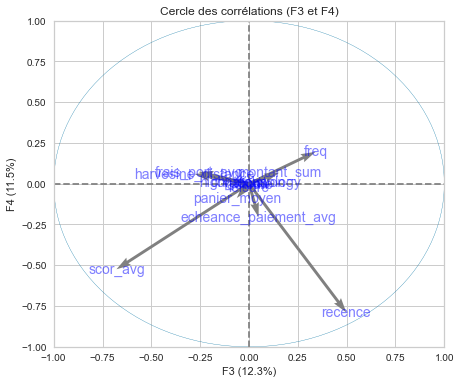

In [110]:
 # Cercle des corrélations
pcs = pca.components_
names=df.index
features=df.columns
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

In [112]:
# ACP avec 6 composantes
n_comp = 6
pca= PCA(n_components=n_comp)
pca.fit(df)
X_projected = pca.transform(df)
pca.explained_variance_ratio_

array([0.28692735, 0.12984039, 0.12263982, 0.1154684 , 0.09519583,
       0.08495884])

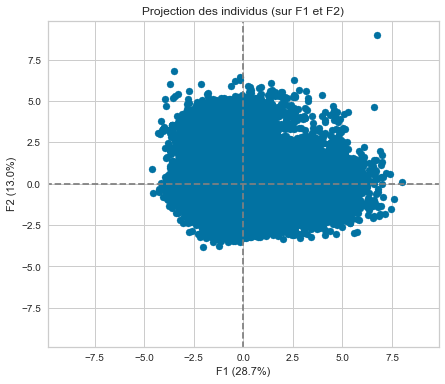

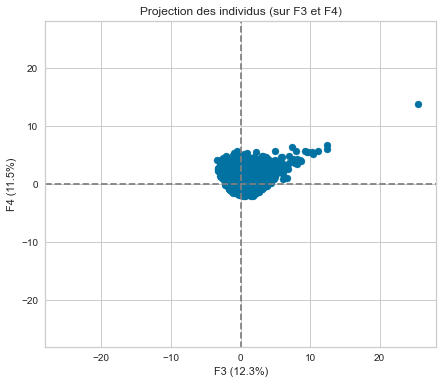

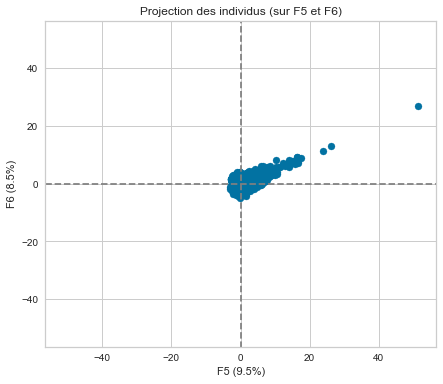

In [113]:
# Projection des individus
X_projected = pca.transform(df)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)])

plt.show()

## Bilan
L'ACP avec les données quantitatives normalisées et standardisées, sans l'ajout des données qualitatives, donne des projections plus homogènes. Elle sera utilisée pour la suite de l'analyse.
L'ajout des variables catégorielles encodées n'apportent rien de plus, ce n'est pas une suprise car pour le moyen de paiement 97% des clients paient en carte de crédit à débit différé et pour les catégories de produits préférés, 96% des clients n'effectuent qu'une seule commande.

##  Tests à 3 features RFM

##  K_Means

In [411]:
X_scaled.describe()

recence   montant_sum  harvesine_distance      scor_avg  \
count  9.121200e+04  9.121200e+04        9.121200e+04  9.121200e+04   
mean  -2.033510e-16  1.236640e-16       -3.470354e-16 -1.641295e-15   
std    1.000005e+00  1.000005e+00        1.000005e+00  1.000005e+00   
min   -5.403015e+00 -2.701081e+00       -6.153046e+00 -2.690498e+00   
25%   -4.340315e-01 -7.062653e-01       -4.908717e-01  4.549600e-02   
50%    2.461290e-01 -8.599984e-02       -6.894515e-02  5.898983e-01   
75%    7.277407e-01  5.545464e-01        4.967316e-01  5.898983e-01   
max    1.462531e+00  7.474230e+00        3.153136e+00  5.898983e-01   

       echeance_paiement_avg  panier_moyen  frais_port_avg          freq  
count           9.121200e+04  9.121200e+04    9.121200e+04  91212.000000  
mean           -6.176690e-16 -6.728198e-17   -2.233993e-16      1.237666  
std             1.000005e+00  1.000005e+00    1.000005e+00      0.844734  
min            -2.072153e+00 -4.181382e+00   -5.782071e+00      1.000000  
25%            -8.545577e-01 -6.666278e-01   -4.865212e-01      1.000000  
50%            -1.423104e-01 -5.627924e-04   -1.037921e-01      1.000000  
75%             7.550151e-01  6.276674e-01    3.794985e-01      1.000000  
max             3.582183e+00  4.919843e+00    6.175126e+00     75.000000

In [16]:
# preparation du dataset avec 3 features
df1=X_scaled[['recence','freq','montant_sum']]

In [415]:
km_scores= []
km_silhouette = []
db_score = []
for i in range(2, len(features)):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

Score for number of cluster(s) 2: -563112.7719384163
Silhouette score for number of cluster(s) 2: 0.21074918645146465
Davies Bouldin score for number of cluster(s) 2: 1.8107142703304688
Score for number of cluster(s) 3: -503384.40952146234
Silhouette score for number of cluster(s) 3: 0.22051756065675113
Davies Bouldin score for number of cluster(s) 3: 1.6188550993028727
Score for number of cluster(s) 4: -461306.48508784844
Silhouette score for number of cluster(s) 4: 0.1991638775227697
Davies Bouldin score for number of cluster(s) 4: 1.5683709608321734
Score for number of cluster(s) 5: -426105.8205724378
Silhouette score for number of cluster(s) 5: 0.2088351850976967
Davies Bouldin score for number of cluster(s) 5: 1.3912117056289457
Score for number of cluster(s) 6: -394297.1318753776
Silhouette score for number of cluster(s) 6: 0.17085911958792277
Davies Bouldin score for number of cluster(s) 6: 1.544258790343644
Score for number of cluster(s) 7: -365704.17503639206
Silhouette score 

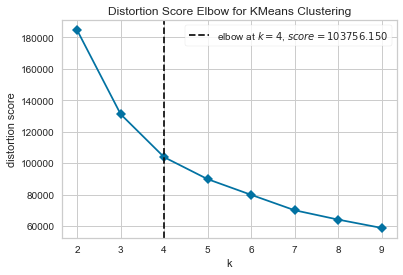

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [413]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10),timings=False)
# Entraîne le modèle
visualizer.fit(df1)
visualizer.show()

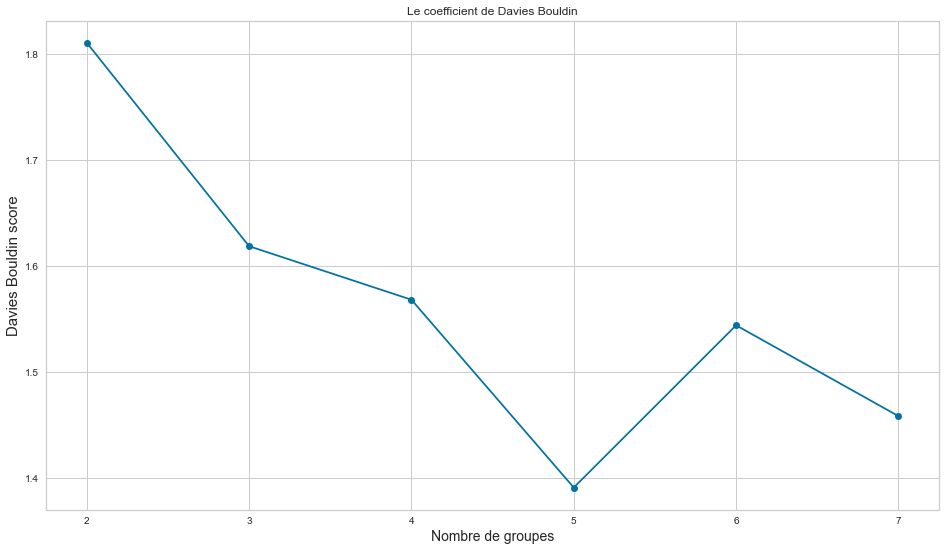

In [416]:
plt.figure(figsize=(16,9))
plt.title("Le coefficient de Davies Bouldin")
plt.plot([i for i in range(2,len(features))], db_score, marker = 'o')
plt.grid(True)
plt.xlabel("Nombre de groupes",fontsize=14)
plt.ylabel("Davies Bouldin score",fontsize=15)
plt.xticks([i for i in range(2,len(features))])
plt.show()

In [18]:
def pca_plot(X, model):
    '''
    Fonction pour appliquer une ACP et afficher les clusters
    sur les deux premières composantes principales
    '''
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    print(pca.explained_variance_ratio_.cumsum())
    X_trans = pca.transform(X)

    fig = plt.figure(figsize=(12, 5))
    model.fit(X)
    sns.relplot(x=X_trans[:, 0], y=X_trans[:, 1],
                hue=model.labels_, kind='scatter',palette='Set1')
    return(model.labels_)

### essai sur K=3,4 et 5

[0.44533385 0.81387108]


array([2, 2, 2, ..., 2, 2, 2])

<Figure size 864x360 with 0 Axes>

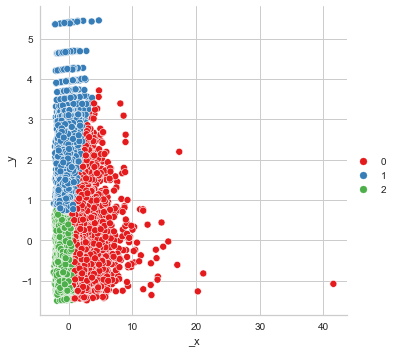

In [418]:
model=cluster.KMeans(n_clusters=3, random_state=0)
pca_plot(df1, model)

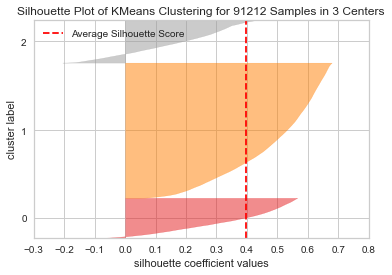

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [421]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df1)    # Fit the data to the visualizer
visualizer.poof() 

[0.44533385 0.81387108]


array([2, 0, 0, ..., 0, 2, 0])

<Figure size 864x360 with 0 Axes>

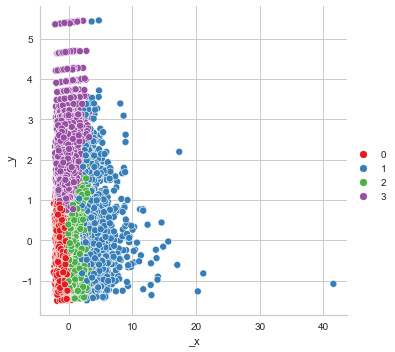

In [19]:
model=cluster.KMeans(n_clusters=4, random_state=0)
pca_plot(df1, model)

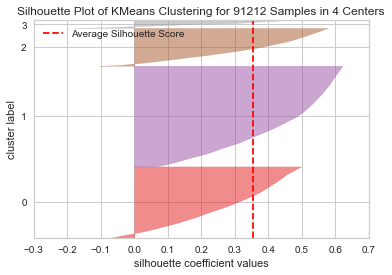

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [414]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df1)    # Fit the data to the visualizer
visualizer.poof()   

<AxesSubplot:title={'center':'T-SNE'}>

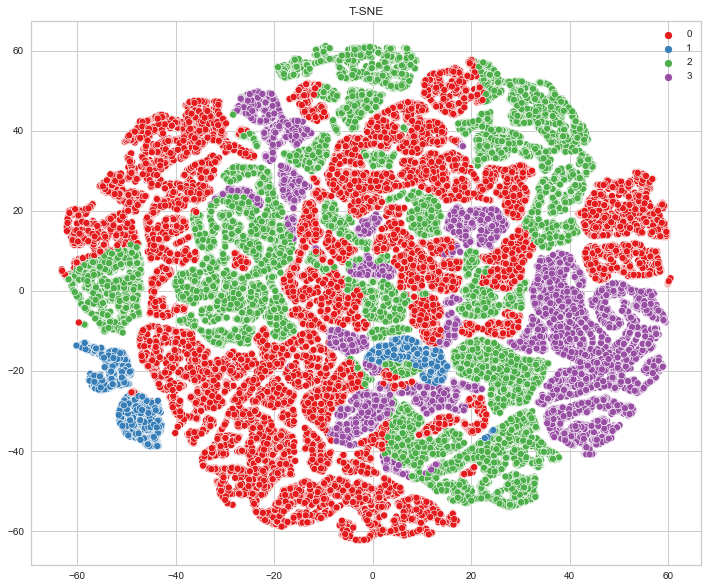

In [21]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(df1)
plt.figure(figsize=(12,10))
plt.title('T-SNE')
sns.scatterplot(T[:,0], T[:,1],hue=model.labels_,palette='Set1')

In [23]:
df_4cluster =  pd.DataFrame(index = data.index)

In [27]:
df_4cluster['Cluster'] = model.labels_

In [28]:
df_4cluster

Cluster
0            2
1            0
2            0
3            0
4            2
...        ...
91207        1
91208        0
91209        0
91210        2
91211        0

[91212 rows x 1 columns]

In [31]:
visu_cluster = pd.concat([data, df_4cluster], axis=1)
visu_cluster = visu_cluster.groupby('Cluster').agg(
                                            {'recence' : 'mean', 
                                             'montant_sum' : 'mean',
                                             'freq' : 'mean',
                                            'scor_avg' : 'mean',
                                            'harvesine_distance' : 'mean',
                                            'echeance_paiement_avg' : 'mean',
                                            'panier_moyen': 'mean'})
visu_cluster.reset_index(inplace = True)
visu_cluster.head()

Cluster     recence  montant_sum      freq  scor_avg  harvesine_distance  \
0        0  284.709951    71.414506  1.042796  4.191322          425.288183   
1        1  236.477946  1341.053831  4.324197  3.649648          437.459138   
2        2  271.137805   327.182209  1.255182  4.057941          488.167200   
3        3   40.410719   146.312833  1.106936  4.339071          426.327170   

   echeance_paiement_avg  panier_moyen  
0               2.170908     55.035813  
1               3.542912    109.214972  
2               3.994179    236.785799  
3               2.675920    108.303681

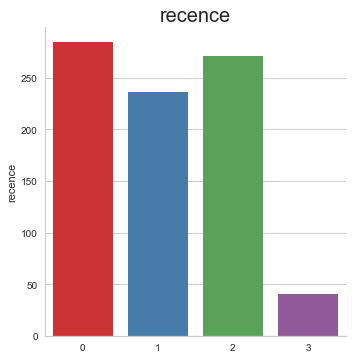

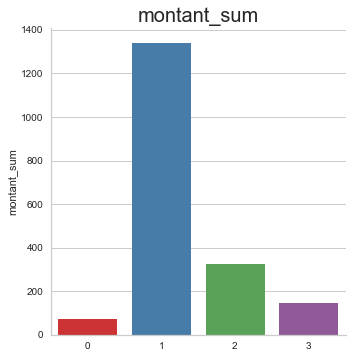

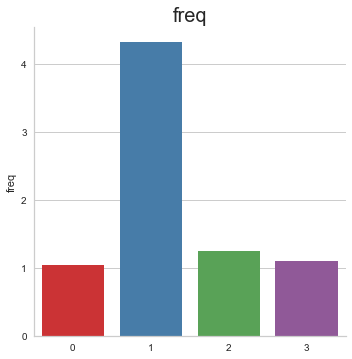

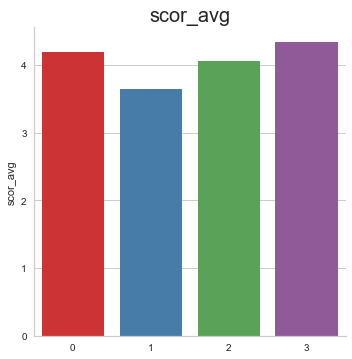

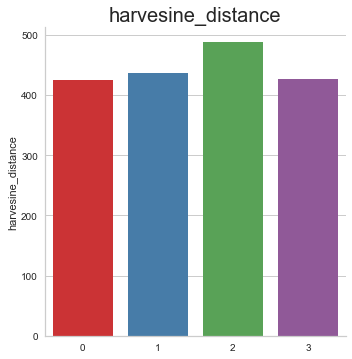

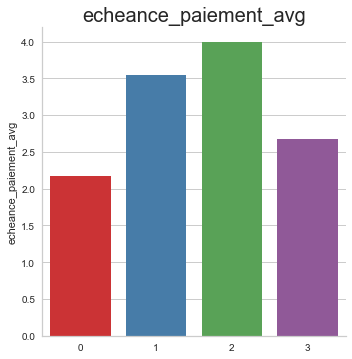

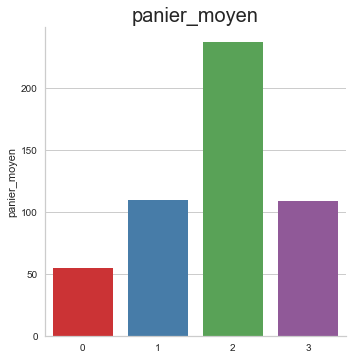

In [33]:
colonnes = ['recence', 'montant_sum', 'freq', 'scor_avg', 'harvesine_distance', 'echeance_paiement_avg','panier_moyen']
for col in colonnes :
    g = sns.catplot(data= visu_cluster, kind="bar", x="Cluster", y=col, palette='Set1')
    g.set_axis_labels("", col)
    plt.title(col, fontsize = 20)
    plt.show()

[0.44533385 0.81387108]


array([2, 4, 2, ..., 2, 2, 4])

<Figure size 864x360 with 0 Axes>

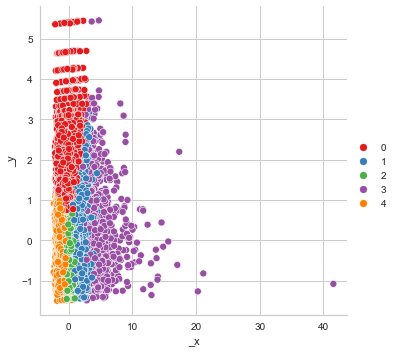

In [28]:
model=cluster.KMeans(n_clusters=5, random_state=0)
pca_plot(df1, model)

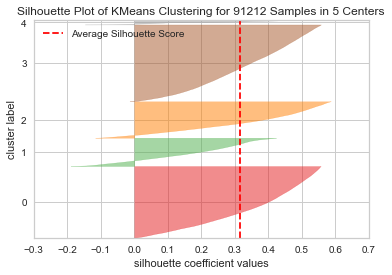

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [417]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df1)    # Fit the data to the visualizer
visualizer.poof() 

<AxesSubplot:title={'center':'T-SNE'}>

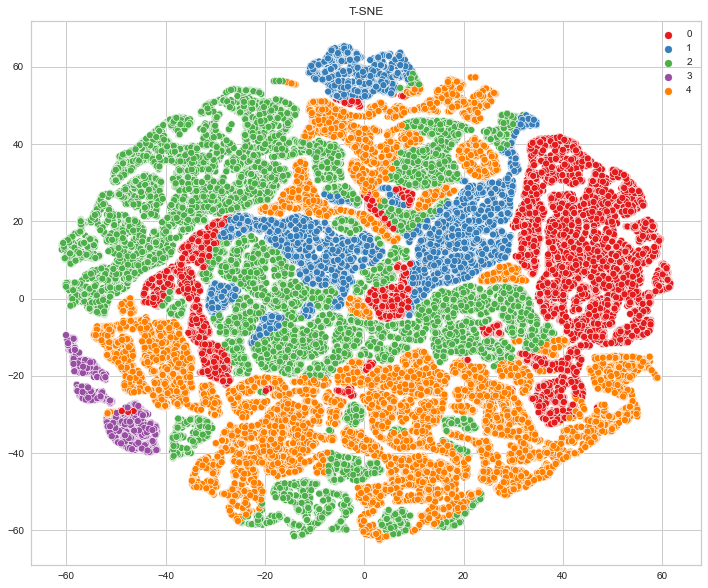

In [29]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(df1)
plt.figure(figsize=(12,10))
plt.title('T-SNE')
sns.scatterplot(T[:,0], T[:,1],hue=model.labels_,palette='Set1')

In [ ]:
model=cluster.KMeans(n_clusters=5, random_state=0)
pca_plot(df1, model)

### Bilan 

D'après les coeff de silhouette et la forme des clusters, le nombre de Cluster à choisir est de 4. Nous essayons par la suite d'étudier le profil des cluster

#### Etude des clusters de K-means

In [34]:
X=data[['recence','freq','montant_sum']]
X_clustered = X.copy()
X_clustered['cluster'] = df_4cluster

In [35]:
X_clustered

recence  freq  montant_sum  cluster
0        111.0   1.0       141.90        2
1        114.0   1.0        27.19        0
2        536.0   1.0        86.22        0
3        320.0   1.0        43.62        0
4        287.0   1.0       196.89        2
...        ...   ...          ...      ...
91207    446.0   2.0      4134.84        1
91208    261.0   1.0        84.58        0
91209    567.0   1.0       112.46        0
91210    118.0   1.0       133.69        2
91211    483.0   1.0        71.56        0

[91212 rows x 4 columns]

In [36]:
# 1 er cluster
X_clustered[X_clustered['cluster'] ==0].describe()

recence          freq   montant_sum  cluster
count  42317.000000  42317.000000  42317.000000  42317.0
mean     284.709951      1.042796     71.414506      0.0
std      133.408852      0.223485     30.058526      0.0
min       58.000000      1.000000     10.070000      0.0
25%      175.000000      1.000000     45.950000      0.0
50%      267.000000      1.000000     68.020000      0.0
75%      384.000000      1.000000     95.430000      0.0
max      694.000000      4.000000    138.490000      0.0

In [37]:
# 2 Cluster
X_clustered[X_clustered['cluster'] ==1].describe()

recence         freq    montant_sum  cluster
count  3174.000000  3174.000000    3174.000000   3174.0
mean    236.477946     4.324197    1341.053831      1.0
std     147.674619     2.680097    2959.061993      0.0
min       0.000000     2.000000      19.000000      1.0
25%     117.000000     3.000000     406.237500      1.0
50%     216.000000     4.000000     698.130000      1.0
75%     334.000000     5.000000    1340.275000      1.0
max     694.000000    75.000000  109312.640000      1.0

In [38]:
# 3 cluster
X_clustered[X_clustered['cluster'] ==2].describe()

recence          freq   montant_sum  cluster
count  29861.000000  29861.000000  29861.000000  29861.0
mean     271.137805      1.255182    327.182209      2.0
std      135.440511      0.457267    308.461413      0.0
min       25.000000      1.000000    102.850000      2.0
25%      160.000000      1.000000    167.280000      2.0
50%      253.000000      1.000000    221.420000      2.0
75%      367.000000      1.000000    353.070000      2.0
max      694.000000      3.000000   6929.310000      2.0

In [39]:
# 4 cluster
X_clustered[X_clustered['cluster'] ==3].describe()

recence          freq   montant_sum  cluster
count  15860.000000  15860.000000  15860.000000  15860.0
mean      40.410719      1.106936    146.312833      3.0
std       24.058346      0.338078    161.625616      0.0
min        0.000000      1.000000      9.590000      3.0
25%       21.000000      1.000000     64.485000      3.0
50%       36.000000      1.000000    108.145000      3.0
75%       61.000000      1.000000    168.842500      3.0
max      101.000000      4.000000   3351.350000      3.0

In [40]:
segt_map = {'2' : 'anciens clients',
            '0' : 'clients perdus',
            '1' : 'clients dépensiers',
            '3' : 'Nouveaux clients'}

X_label = X_clustered.copy()
X_label['label_4_cls'] = X_label['cluster'].astype(str).replace(segt_map, regex=True)

In [41]:
def count_segment(labels):
    '''
    Fonction pour compter le nombre de points
    dans chaque cluster
    '''
    segments_counts = labels.value_counts().sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(5, 5))

    bars = ax.barh(range(len(segments_counts)),
                   segments_counts)
    ax.set_frame_on(False)
    ax.tick_params(left=False,
                   bottom=False,
                   labelbottom=False)
    ax.set_yticks(range(len(segments_counts)))
    ax.set_yticklabels(segments_counts.index)

    for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                     round(value*100/segments_counts.sum(),
                                           1)),
                va='center',
                ha='left'
                )
    plt.title("Répartition des clients par cluster")
    plt.show()


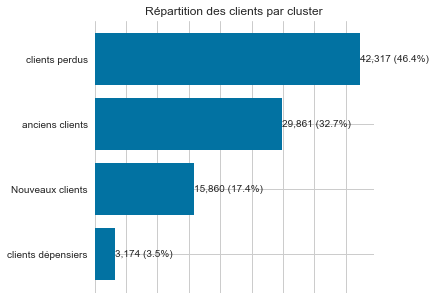

In [42]:
count_segment(X_label['label_4_cls'])

## DBSCAN 

L'algorithme DBSCAN utilise 2 paramètres :

La distance epsilon
Le nombre minimum de points MinPts devant se trouver
dans un rayon epsilon pour que ces points soient considérés
comme un cluster.
Les paramètres d'entrées sont donc une estimation de la densité
de points des clusters.
L'idée de base de l'algorithme est ensuite, pour un point donné,
de récupérer son epsilon-voisinage et de vérifier qu'il contient bien
MinPts points ou plus.
Ce point est alors considéré comme faisant partie d'un cluster.
On parcourt ensuite l'epsilon-voisinage de proche en proche afin
de trouver l'ensemble des points du cluster.


In [16]:
dbs = DBSCAN(eps = 0.7,min_samples=15,n_jobs=-1).fit(df1)

<AxesSubplot:title={'center':'DBSCAN via T-SNE'}>

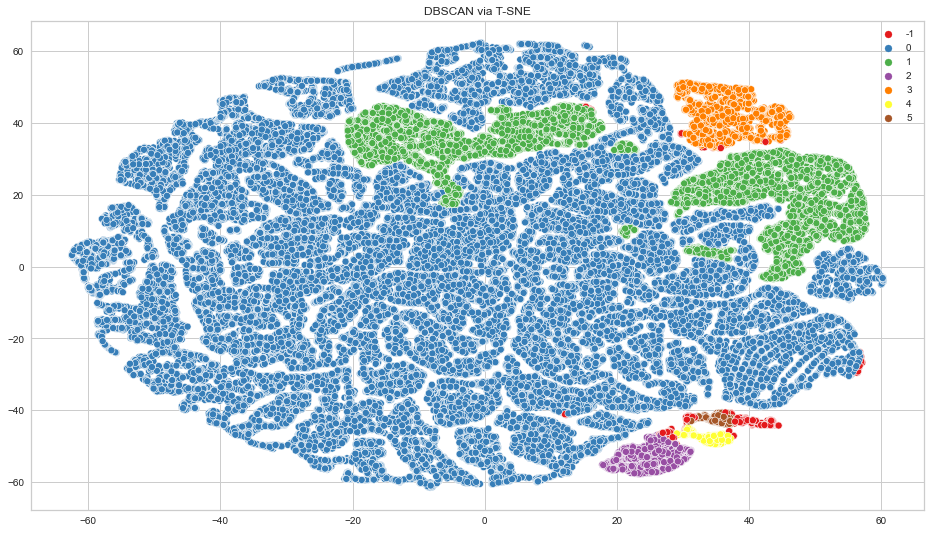

In [19]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(df1)
plt.figure(figsize=(16,9))
plt.title('DBSCAN via T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_,palette='Set1')

### Bilan

L'utilisation de DBSCAN dans notre cas nous semble inexploitable pour une utilisation métier car les clusters ne sont pas équilibrés.
Nous décidons d'abandonner cette méthode pour la suite 

## Classification hierarchique

Hyperparamètres :

n_clusters : int ou None, default=2, le nombre de clusters à trouver. Il doit être None si distance_threshold n'est pas None.

affinity : str ou appelable, par défaut='euclidienne'. Métrique utilisée pour calculer le lien. Peut être "euclidienne", "l1", "l2", "manhattan", "cosinus" ou "précalculée". Si le lien est "ward", seul "euclidien" est accepté. Si "precomputed", une matrice de distance (au lieu d'une matrice de similarité) est nécessaire comme entrée pour la méthode d'ajustement.

linkage : {'ward', 'complete', 'average', 'single'}, default='ward', lLe critère de liaison à utiliser. Le critère de liaison détermine la distance à utiliser entre les ensembles d'observations. L'algorithme fusionnera les paires de cluster qui minimisent ce critère.
*'ward' minimise la variance des clusters fusionnés.
*'average' utilise la moyenne des distances de chaque observation des deux ensembles.
*Le lien 'complet' ou 'maximum' utilise les distances maximales entre toutes les observations des deux ensembles.
*single' utilise le minimum des distances entre toutes les observations des deux ensembles.

In [31]:
aggclu = AgglomerativeClustering(n_clusters = None, distance_threshold=0).fit(df1.sample(frac = 0.3))

In [32]:
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram'''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

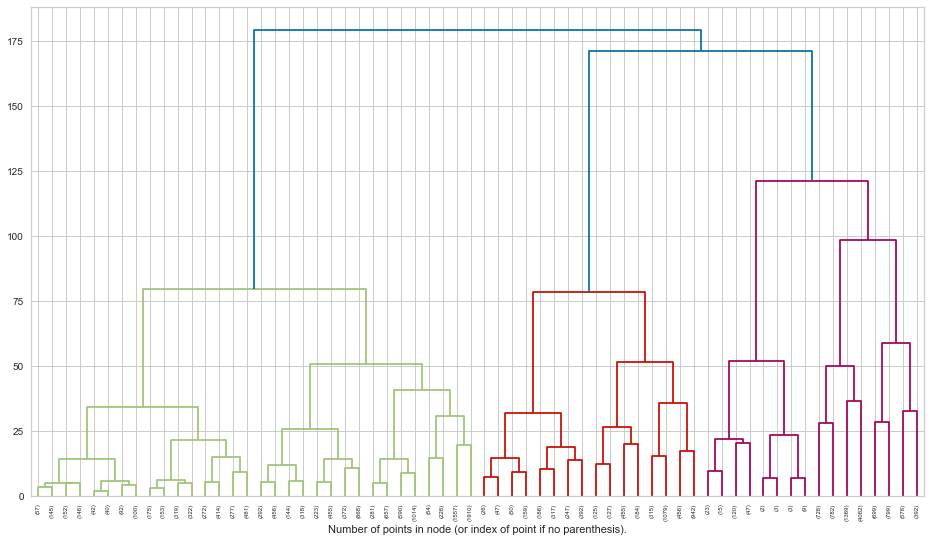

In [33]:
plt.figure(figsize=(16,9))
plot_dendrogram(aggclu, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
Pour la suite nous optons pour le modèle K_Means pour notre segmentation

# Test avec 4 features

## RFM + feature distance

In [34]:
# preparation du dataset avec 3 features
df2=X_scaled[['recence','freq','montant_sum','harvesine_distance']]

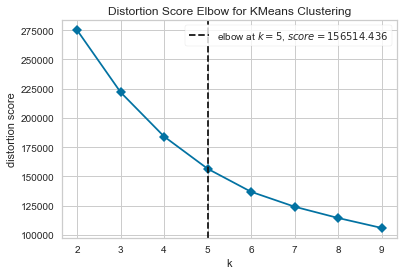

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10),timings=False)
# Entraîne le modèle
visualizer.fit(df2)
visualizer.show()

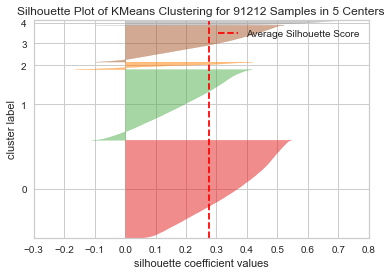

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [36]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df2)    # Fit the data to the visualizer
visualizer.poof() 

### RFM + Feature 'scor_avg'

In [37]:
# preparation du dataset avec 5 features
df3=X_scaled[['recence','freq','montant_sum','scor_avg']]

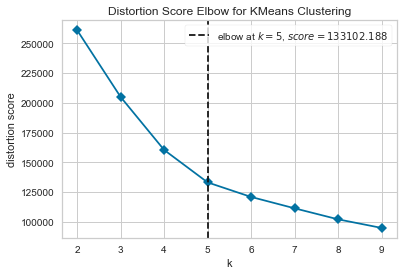

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10),timings=False)
# Entraîne le modèle
visualizer.fit(df3)
visualizer.show()

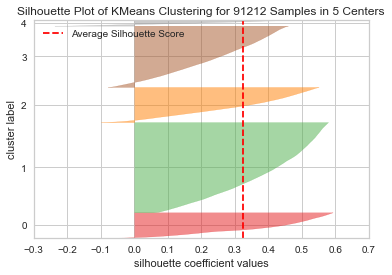

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df3)    # Fit the data to the visualizer
visualizer.poof() 

[0.33931675 0.61230897]


array([0, 2, 2, ..., 2, 0, 2])

<Figure size 864x360 with 0 Axes>

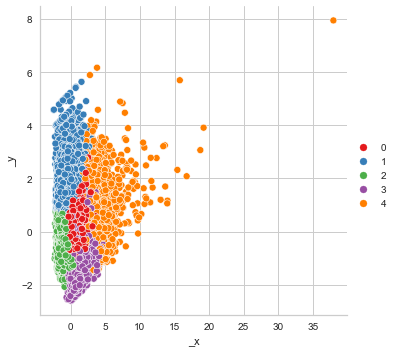

In [42]:
model=cluster.KMeans(n_clusters=5, random_state=0)
pca_plot(df3, model)

<AxesSubplot:title={'center':'T-SNE'}>

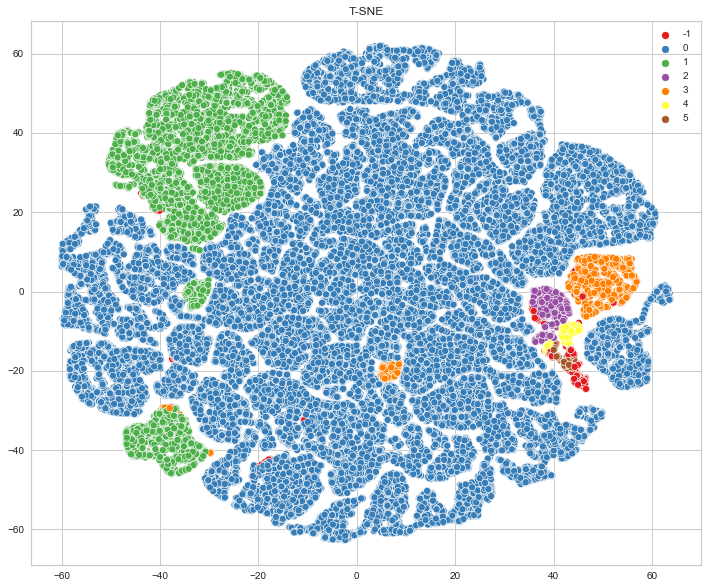

In [43]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(df3)
plt.figure(figsize=(12,10))
plt.title('T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_,palette='Set1')

### RFM + 'scor_avg'+ 'echeance paiement_avg'

In [44]:
# preparation du dataset avec 5 features
df4=X_scaled[['recence','freq','montant_sum','scor_avg','echeance_paiement_avg']]

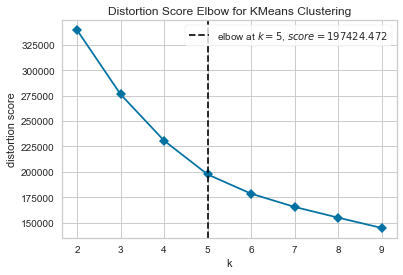

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
#Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10),timings=False)
# Entraîne le modèle
visualizer.fit(df4)
visualizer.show()

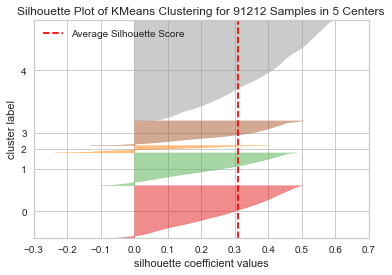

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [46]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df4)    # Fit the data to the visualizer
visualizer.poof() 

### RFM + 'scor_avg'+ 'frais_port_avg'

In [47]:
# preparation du dataset avec 5 features
df5=X_scaled[['recence','freq','montant_sum','scor_avg','frais_port_avg']]

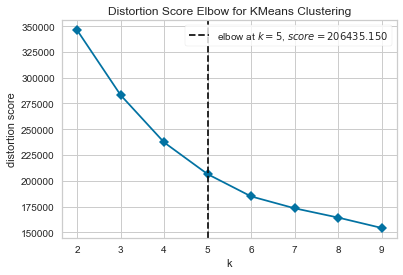

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
#Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10),timings=False)
# Entraîne le modèle
visualizer.fit(df5)
visualizer.show()

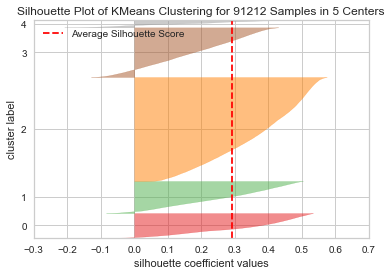

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df5)    # Fit the data to the visualizer
visualizer.poof() 

[0.32324229 0.54257455]


array([1, 1, 1, ..., 1, 1, 1])

<Figure size 864x360 with 0 Axes>

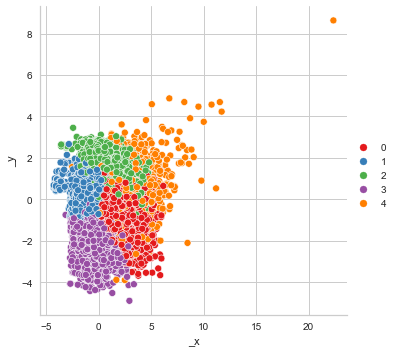

In [50]:
model=cluster.KMeans(n_clusters=5, random_state=0)
pca_plot(df5, model)

<AxesSubplot:title={'center':'T-SNE'}>

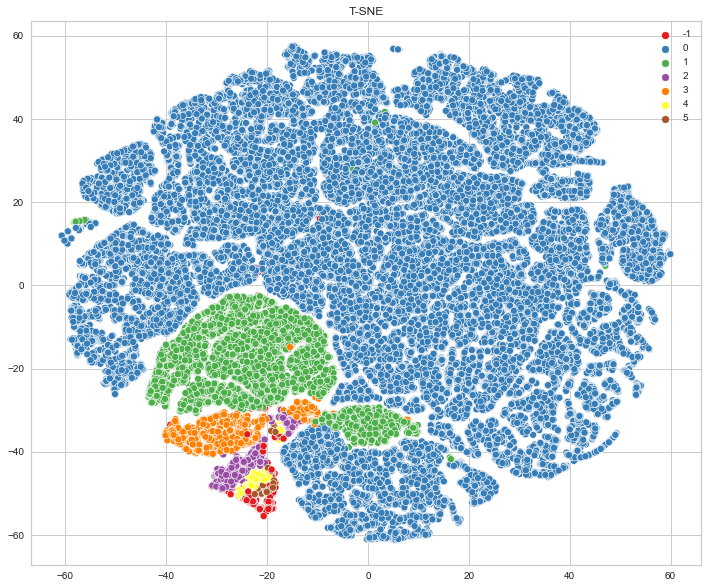

In [51]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(df5)
plt.figure(figsize=(12,10))
plt.title('T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_,palette='Set1')

## Bilan 


Après des ajouts de features et compte tenu du score de silhouette nous gardons les features RFM avec une segmentation sur 4 clusters avec le K_Means 


## Stabilité
Pour mesurer la stabiltié de nos clusters. On va évaluer la stabilité entre différentes dates via le score ARI.

In [173]:
# Dataframe de sauvegarde des scores ARI de stabilité d'initialisation
df_stabilite_init = pd.DataFrame()

In [174]:
seed=20

In [175]:
def calcul_stabilite_initialisation(nom_algo, model, data, dataframe_resultat,
                                    nb_iter=25):
    '''
    CALCUL DES METRIQUES pour évaluer la stabilité d'initialisation.
    Parameters
    '''
    
   
    # Initialise la liste des partitions
    partitions = []

    # Boucle sur le nombre d'itération choisi (25 )
    for i in range(nb_iter):

        # Entraînement du modèle
        model.fit(data)

        # Labels des clusters
        partitions.append(model.labels_)

    # Computing the ARI scores between partition

    # Initializing list of ARI scores
    ARI_scores = []

    # For each partition, except last one
    for i in range(nb_iter - 1):
        # Compute the ARI score with other partitions
        for j in range(i + 1, nb_iter):
            ARI_score = adjusted_rand_score(partitions[i], partitions[j])
            ARI_scores.append(ARI_score)

    # Compute the mean and standard deviation of ARI scores
    ARI_mean = statistics.mean(ARI_scores)
    ARI_std = statistics.stdev(ARI_scores)

    dataframe_resultat = dataframe_resultat.append(pd.DataFrame({
        'Algos': [nom_algo],
        'ARI_mean': [ARI_mean],
        'ARI_std': [ARI_std]
    }), ignore_index=True)

    return dataframe_resultat


In [176]:
model = KMeans(n_clusters=3,
               init='k-means++')
# Score de stabilité d'initialisation
df_stabilite_init = calcul_stabilite_initialisation('K_Means_3',
                                                        model,
                                                          df3,
                                                        df_stabilite_init)
df_stabilite_init.style.hide_index()

In [177]:
model = KMeans(n_clusters=4,
               init='k-means++')
# Score de stabilité d'initialisation
df_stabilite_init = calcul_stabilite_initialisation('K_Means_4',
                                                        model,
                                                        df3,
                                                        df_stabilite_init)
df_stabilite_init.style.hide_index()


In [178]:
model = KMeans(n_clusters=5,
               init='k-means++')
# Score de stabilité d'initialisation
df_stabilite_init = calcul_stabilite_initialisation('K_Means_5',
                                                        model,
                                                        df3,
                                                        df_stabilite_init)
df_stabilite_init.style.hide_index()

In [179]:
model = KMeans(n_clusters=6,
               init='k-means++')
# Score de stabilité d'initialisation
df_stabilite_init = calcul_stabilite_initialisation('K_Means_6',
                                                        model,
                                                        df3,
                                                        df_stabilite_init)
df_stabilite_init.style.hide_index()

 ### Bilan 
 la stabilité d'initialisation (proche de 1) est favorable à K-Means 4 clusters

## Stabilité des clusters au cours du temps

In [198]:
X_scaled

recence  montant_sum  harvesine_distance  scor_avg  \
0     -0.452601     0.163922           -0.490847  0.589898   
1     -0.424869    -1.623161           -0.534460  0.045496   
2      1.191941    -0.379643           -0.867281 -0.620799   
3      0.652093    -1.117575            1.837422  0.045496   
4      0.538281     0.522363           -0.701886  0.589898   
...         ...          ...                 ...       ...   
91207  0.999485     3.869044            1.676819  0.589898   
91208  0.439015    -0.400542            1.402492  0.045496   
91209  1.250823    -0.090068            1.285843  0.589898   
91210 -0.388997     0.098778            0.620235  0.589898   
91211  1.082920    -0.582245           -3.905330  0.589898   

       echeance_paiement_avg  panier_moyen  frais_port_avg  freq  
0                   1.787532      0.545960       -0.685602   1.0  
1                  -0.854558     -1.544775       -1.353244   1.0  
2                   1.787532     -0.148769       -0.014861   1.0  
3                   0.755015     -1.206537        0.029356   1.0  
4                   1.346068      0.905638       -0.051178   1.0  
...                      ...           ...             ...   ...  
91207               2.140034      2.535483        5.186582   2.0  
91208              -0.854558     -0.215928        0.237744   1.0  
91209              -0.854558      0.141209        0.495850   1.0  
91210               1.075284      0.411836        0.139310   1.0  
91211               0.755015     -0.357680       -0.327160   1.0  

[91212 rows x 8 columns]

In [207]:
df_stab = data.copy()
df_stab = df_stab.reset_index()

In [210]:
df_stab

index                customer_unique_id       customer_city  \
0          0  0000366f3b9a7992bf8c76cfdf3221e2             cajamar   
1          1  0000b849f77a49e4a4ce2b2a4ca5be3f              osasco   
2          2  0000f46a3911fa3c0805444483337064            sao jose   
3          3  0000f6ccb0745a6a4b88665a16c9f078               belem   
4          4  0004aac84e0df4da2b147fca70cf8255            sorocaba   
...      ...                               ...                 ...   
91207  91207  fffcf5a5ff07b0908bd4e2dbc735a684             sanharo   
91208  91208  fffea47cd6d3cc0a88bd621562a9d061    feira de santana   
91209  91209  ffff371b4d645b6ecea244b27531430a               sinop   
91210  91210  ffff5962728ec6157033ef9805bacc48  bom jesus do norte   
91211  91211  ffffd2657e2aad2907e67c3e9daecbeb         campo largo   

      customer_state product_category_name  recence  freq  montant_sum  \
0                 SP                  home    111.0   1.0       141.90   
1                 SP               fashion    114.0   1.0        27.19   
2                 SC               various    536.0   1.0        86.22   
3                 PA       high_technology    320.0   1.0        43.62   
4                 SP       high_technology    287.0   1.0       196.89   
...              ...                   ...      ...   ...          ...   
91207             PE               fashion    446.0   2.0      4134.84   
91208             BA               fashion    261.0   1.0        84.58   
91209             MT               various    567.0   1.0       112.46   
91210             ES               various    118.0   1.0       133.69   
91211             PR               fashion    483.0   1.0        71.56   

       harvesine_distance   date_dernier_achat  scor_avg  \
0              211.642212  2018-05-10 10:56:27       5.0   
1              203.596053  2018-05-07 11:11:27       4.0   
2              151.425065  2017-03-10 21:05:03       3.0   
3             1666.119944  2017-10-12 20:29:41       4.0   
4              175.435816  2017-11-14 19:45:42       5.0   
...                   ...                  ...       ...   
91207         1445.362403  2017-06-08 21:00:36       5.0   
91208         1133.762078  2017-12-10 20:07:56       4.0   
91209         1022.524806  2017-02-07 15:49:16       5.0   
91210          567.106728  2018-05-02 15:17:41       5.0   
91211            9.377757  2017-05-02 20:18:45       5.0   

       echeance_paiement_avg  panier_moyen moyen_paiement_prefere  \
0                        8.0        129.90            credit_card   
1                        1.0         18.90            credit_card   
2                        8.0         69.00            credit_card   
3                        4.0         25.99            credit_card   
4                        6.0        180.00            credit_card   
...                      ...           ...                    ...   
91207                   10.0        785.00            credit_card   
91208                    1.0         64.89            credit_card   
91209                    1.0         89.90            credit_card   
91210                    5.0        115.00            credit_card   
91211                    4.0         56.99            credit_card   

       frais_port_avg  
0               12.00  
1                8.29  
2               17.22  
3               17.63  
4               16.89  
...               ...  
91207          248.71  
91208           19.69  
91209           22.56  
91210           18.69  
91211           14.57  

[91212 rows x 15 columns]

In [208]:
# Détermination des dates de référence
# ---------------------------------------------------------------------
# Date de référence de la période complète ?
date_reference = df_stab['date_dernier_achat'].max()
print(f'Data de référence période complète : {date_reference}')
# Data de référence transformée
date_reference = pd.to_datetime(date_reference,
                                format='%Y-%m-%d %H:%M:%S')


Data de référence période complète : 2018-08-29 15:00:37


In [209]:
# Data de référence de la première période historique - 1 mois
data_ref_1mois = date_reference - pd.DateOffset(months=1)
print(f'Data de référence histo - 1 mois : {data_ref_1mois}')
# Data de référence de la première période historique - 2 mois
data_ref_2mois = date_reference - pd.DateOffset(months=2)
print(f'Data de référence histo - 2 mois : {data_ref_2mois}')
# Data de référence de la première période historique - 3 mois
data_ref_3mois = date_reference - pd.DateOffset(months=3)
print(f'Data de référence histo - 3 mois : {data_ref_3mois}')
# Data de référence de la première période historique - 4 mois
data_ref_4mois = date_reference - pd.DateOffset(months=4)
print(f'Data de référence histo - 4 mois : {data_ref_2mois}')
# Data de référence de la première période historique - 5 mois
data_ref_5mois = date_reference - pd.DateOffset(months=5)
print(f'Data de référence histo - 5 mois : {data_ref_2mois}')
# Data de référence de la première période historique - 6 mois
data_ref_6mois = date_reference - pd.DateOffset(months=6)
print(f'Data de référence histo - 6 mois : {data_ref_6mois}')
# Data de référence de la première période historique - 7 mois
data_ref_7mois = date_reference - pd.DateOffset(months=7)
print(f'Data de référence histo - 7 mois : {data_ref_7mois}')
# Data de référence de la première période historique - 8 mois
data_ref_8mois = date_reference - pd.DateOffset(months=8)
print(f'Data de référence histo - 8 mois : {data_ref_8mois}')
# Data de référence de la première période historique - 9 mois
data_ref_9mois = date_reference - pd.DateOffset(months=9)
print(f'Data de référence histo - 9 mois : {data_ref_9mois}')
# Data de référence de la première période historique - 10 mois
data_ref_10mois = date_reference - pd.DateOffset(months=10)
print(f'Data de référence histo - 10 mois : {data_ref_10mois}')
# Data de référence de la première période historique - 11 mois
data_ref_11mois = date_reference - pd.DateOffset(months=11)
print(f'Data de référence histo - 11 mois : {data_ref_11mois}')
# Data de référence de la première période historique - 1 an
data_ref_12mois = date_reference - pd.DateOffset(months=12)
print(f'Data de référence histo - 1 an : {data_ref_12mois}')

Data de référence histo - 1 mois : 2018-07-29 15:00:37
Data de référence histo - 2 mois : 2018-06-29 15:00:37
Data de référence histo - 3 mois : 2018-05-29 15:00:37
Data de référence histo - 4 mois : 2018-06-29 15:00:37
Data de référence histo - 5 mois : 2018-06-29 15:00:37
Data de référence histo - 6 mois : 2018-02-28 15:00:37
Data de référence histo - 7 mois : 2018-01-29 15:00:37
Data de référence histo - 8 mois : 2017-12-29 15:00:37
Data de référence histo - 9 mois : 2017-11-29 15:00:37
Data de référence histo - 10 mois : 2017-10-29 15:00:37
Data de référence histo - 11 mois : 2017-09-29 15:00:37
Data de référence histo - 1 an : 2017-08-29 15:00:37


### Protocole :

On conserve un dataframe de référence.
On sélectionne les clients sur une période historique (ex 1 mois).
On entraine un algorithme KMeans sur cette période historique ==> les clients sont classés dans des groupes.
On entraîne un algorithme KMeans sur la période de référence, en ne conservant que les clients présents sur la période historique ==> les clients sont classés dans des groupes.
On compare les groupes des clients.

In [300]:
def segmentation_kmean_periode(dataframe, dataframe_resutat, date_ref, titre,
                               nb_clusters):
    '''
    Segmentation de clientèle à partir d'une date + métrique de stabilité.
    Parameters
    '''

    # ------------------------------------------------------------------------
    # Préparation des dataframes de travail
    # ------------------------------------------------------------------------
    dataframe['date_dernier_achat'] = pd.to_datetime(dataframe['date_dernier_achat'],
                       format='%Y-%m-%d %H:%M:%S')
    df_copie = dataframe.copy()
    # Création des 2 tables de comparaison de la stabilité
    df_hist = df_copie[df_copie['date_dernier_achat'] < date_ref]

    # On garde les clients qui étaient dans la base de données sur la période
    # historique
    df_copie_ref = dataframe.copy()
    df_ref = df_copie_ref[df_copie_ref.customer_unique_id.isin(
        df_hist.customer_unique_id)]

    # Sélection des variables numériques
    cols_num_cat = (['recence','freq','montant_sum','scor_avg'])
    # Transformation en logarithme pour avoir le même poids
    col_to_log_cat = cols_num_cat
    df_hist[col_to_log_cat] = df_hist[col_to_log_cat].apply(np.log1p, axis=1)
    df_ref[col_to_log_cat] = df_ref[col_to_log_cat].apply(np.log1p, axis=1)

    # Standardisation StandardScaler - variable transformées en log
    # -----------------------------------------------------------------------
    # Préparation des données
    X_df_hist = df_hist[cols_num_cat].values
    features_df_hist = df_hist[cols_num_cat].columns
    # Standardisation avec StandardScaler (centre, réduit et rend plus la
    # distribution plus normale)
    scaler = StandardScaler()
    X_scaled_hist = scaler.fit_transform(X_df_hist)
    # Dataframe
    X_scaled_hist = pd.DataFrame(X_scaled_hist,
                                 index=df_hist[col_to_log_cat].index,
                                 columns=features_df_hist)
    
    X_df_ref = df_ref[cols_num_cat].values
    features_df_ref = df_ref[cols_num_cat].columns
    # Standardisation avec StandardScaler (centre, réduit et rend plus la
    # distribution plus normale)
    scaler = StandardScaler()
    X_scaled_ref = scaler.fit_transform(X_df_ref)  
    # Dataframe
    X_scaled_ref = pd.DataFrame(X_scaled_ref,
                                index=df_ref[col_to_log_cat].index,
                                columns=features_df_ref)
   
    # ------------------------------------------------------------------------
    # Clustering Kmeans sur les 2 périodes historique et de référence
    # ------------------------------------------------------------------------
    # Instanciation de kmeans
    kmeans = KMeans(n_clusters=nb_clusters, 
                    n_init=20,
                    init='k-means++')
    # Entaînement de kmeans sur la période historique
    kmeans.fit(X_scaled_hist)
    kmeans_labels_hist = kmeans.labels_
    X_scaled_hist['Cluster'] = kmeans.labels_
    # Entaînement de sur la période de référence
    kmeans.fit(X_scaled_ref)
    kmeans_labels_ref = kmeans.labels_
    X_scaled_ref['Cluster'] = kmeans.labels_

    # ------------------------------------------------------------------------
    # Scoring ARI de la stabilité
    # ------------------------------------------------------------------------
    # Calcul du score ARI
    ARI_kmeans = metrics.adjusted_rand_score(kmeans_labels_ref,
                                             kmeans_labels_hist)

    # Sauvegarde de l'ARI dans le tableau de résultats
    dataframe_resutat = dataframe_resutat.append(pd.DataFrame({
        'Periode': [titre],
        'Date' : [date_ref],
        'ARI': [ARI_kmeans]}),
        ignore_index=True)

    return dataframe_resutat, X_scaled_hist, X_scaled_ref


In [301]:
# Dataframe de sauvegarde des métriques de stabilité du dataframe
df_resultats_km = pd.DataFrame({})

In [302]:
# Score de stabilité ARI sur la période juillet-août 2018 - 1 mois
df_resultats_km, df_hist_1mois, df_ref_1mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_1mois,
                                                   '1 mois_Juillet_août',
                                                   4)

In [303]:
# Score de stabilité ARI sur la période juin-août 2018 - 2 mois
df_resultats_km, df_hist_2mois, df_ref_2mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_2mois,
                                                   '2 mois_Juin_août',
                                                   4)

In [304]:
# Score de stabilité ARI sur la période juin-août 2018 - 2 mois
df_resultats_km, df_hist_3mois, df_ref_3mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_3mois,
                                                   '3 mois_Juin_août',
                                                   4)

In [305]:
# Score de stabilité ARI sur la période Avril-août 2018 - 4 mois
df_resultats_km, df_hist_4mois, df_ref_4mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_4mois,
                                                   '4 mois_Avril_août',
                                                   4)

In [306]:
# Score de stabilité ARI sur la période mars-août 2018 - 5 mois
df_resultats_km, df_hist_5mois, df_ref_5mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_5mois,
                                                   '5 mois_Mars_août',
                                                   4)

In [307]:
# Score de stabilité ARI sur la période février-août 2018 - 6 mois
df_resultats_km, df_hist_6mois, df_ref_6mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_6mois,
                                                   '6 mois_Février_août',
                                                   4)

In [308]:
# Score de stabilité ARI sur la période janvier-août 2018 - 7 mois
df_resultats_km, df_hist_7mois, df_ref_7mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_7mois,
                                                   '7 mois_Janvier_août',
                                                    4)

In [309]:
# Score de stabilité ARI sur la période décembre-août 2018 - 8 mois
df_resultats_km, df_hist_8mois, df_ref_8mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_8mois,
                                                   '8 mois_Décembre_août',
                                                   4)

In [310]:
# Score de stabilité ARI sur la période novembre-août 2018 - 9 mois
df_resultats_km, df_hist_9mois, df_ref_9mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_9mois,
                                                   '9 mois_Novembre_août',
                                                   4)

In [311]:
# Score de stabilité ARI sur la période octobre-août 2018 - 10 mois
df_resultats_km, df_hist_10mois, df_ref_10mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_10mois,
                                                   '10 mois_Octobre_août',
                                                   4)

In [312]:
# Score de stabilité ARI sur la période septembre-août 2018 - 11 mois
df_resultats_km, df_hist_11mois, df_ref_11mois = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_11mois,
                                                   '11 mois_Septembre_août',
                                                   4)

In [313]:
# Score de stabilité ARI sur la période septembre 2017 -août 2018 - 1
df_resultats_km, df_hist_1an, df_ref_1an = segmentation_kmean_periode(df_stab,
                                                   df_resultats_km,
                                                   data_ref_12mois,
                                                   '1an_aout17_août18',
                                                   4)

In [314]:
df_resultats_km.style.hide_index()

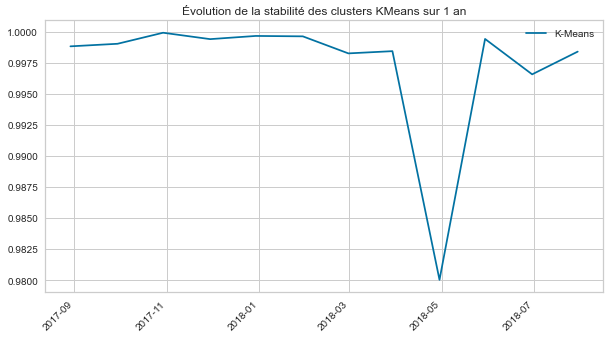

In [315]:
# Visualisation graphique
plt.figure(figsize=(10, 5))
x = df_resultats_km['Date']
plt.plot(df_resultats_km['Date'], df_resultats_km['ARI'], label='K-Means')
plt.legend()
plt.title('Évolution de la stabilité des clusters KMeans sur 1 an')
plt.xticks(rotation='45', horizontalalignment="right")

plt.show()

# Bilan

Nous observons que l'Adjusted_Rand_Score n'est plus 'relativement'stable au cours du temps et commence à chuter à partir de 6,5 mois.
Dans une simulation de contrat de maintenance je proposerai un recalcul des clusters tous les 6 mois